In [2]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Plot of streamflow observations and residuals

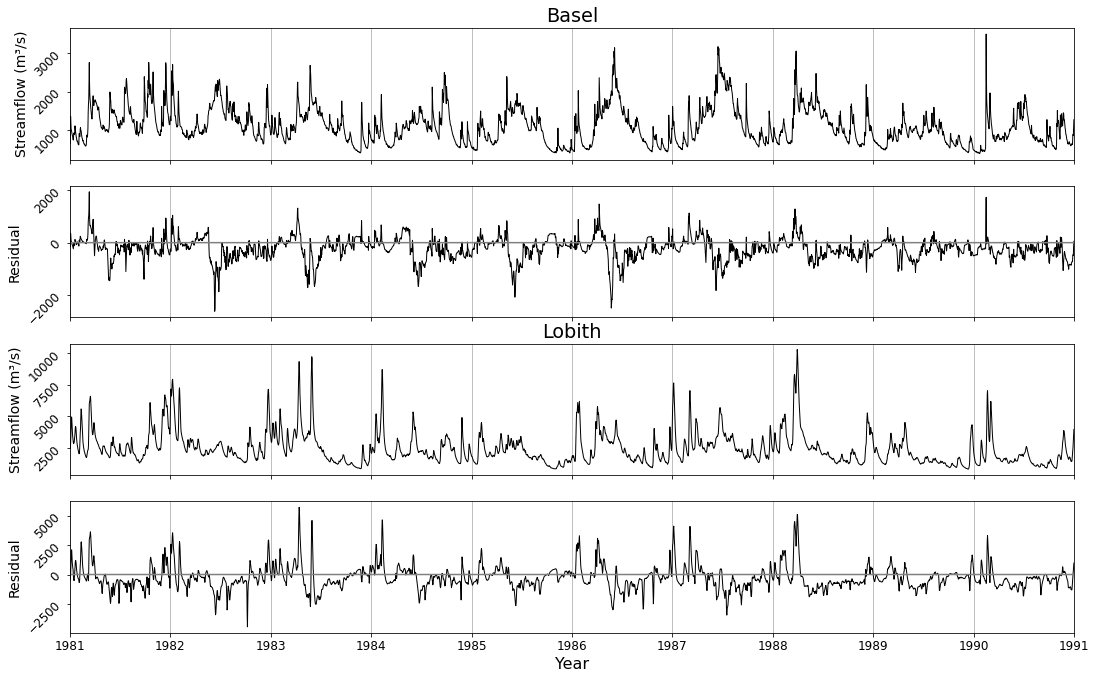

In [ ]:
shown_data = 0.5

#import the data
q_basel = pd.read_csv('/content/drive/MyDrive/ADS/Final Thesis Project/data/q_basel.csv')
q_lobith = pd.read_csv('/content/drive/MyDrive/ADS/Final Thesis Project/data/q_lobith.csv')

if q_basel.shape[0] != q_lobith.shape[0]:
  raise ValueError('The number of observations does not coincide.')

len = q_basel.shape[0]

q_basel = q_basel.iloc[:int(len*shown_data), :]
q_lobith = q_lobith.iloc[:int(len*shown_data), :]

len = q_basel.shape[0]

#extract the observations, residuals and dates
obs_b = q_basel['obs'].values
res_b = q_basel['res'].values

obs_l = q_lobith['obs'].values
res_l = q_lobith['res'].values

yr = q_basel['datetime'].str[:4].values

#plot the observations and residuals
plt.rcParams.update({'font.size': 16})

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(18, 18*2/(1+5**0.5)))
ax1.plot(obs_b, 'k',  linewidth='1')
ax2.plot(res_b, 'k',  linewidth='1')
ax3.plot(obs_l, 'k',  linewidth='1')
ax4.plot(res_l, 'k',  linewidth='1')
ax2.plot(np.zeros(len), color='gray')
ax4.plot(np.zeros(len), color='gray')

#set the ticks
days_per_year = [0]+[365, 365, 365, 366]*5
ticks = np.cumsum(days_per_year[:-1])[:int(20*shown_data)]
plt.xticks(ticks.tolist() + [len], 
           yr[ticks].tolist() + [str(int(yr[-1]) + 1)])
#tweak the axes
ax1.title.set_text('Basel')
ax3.title.set_text('Lobith')
ax4.set_xlabel('Year')
ax1.set_ylabel('Streamflow (m³/s)', fontsize = 14)
ax2.set_ylabel('Residual', fontsize = 14)
ax3.set_ylabel('Streamflow (m³/s)', fontsize = 14)
ax4.set_ylabel('Residual', fontsize = 14)
plt.xlim([0, len])
for ax in (ax1, ax2, ax3, ax4):
  ax.grid(axis = 'x')
  ax.tick_params(axis='y', labelsize=12,  rotation = 45)
  ax.tick_params(axis='x', labelsize=12)


plt.savefig('/content/drive/MyDrive/ADS/Final Thesis Project/output/obs_res.png',bbox_inches='tight')

## Plot of predictions vs observations

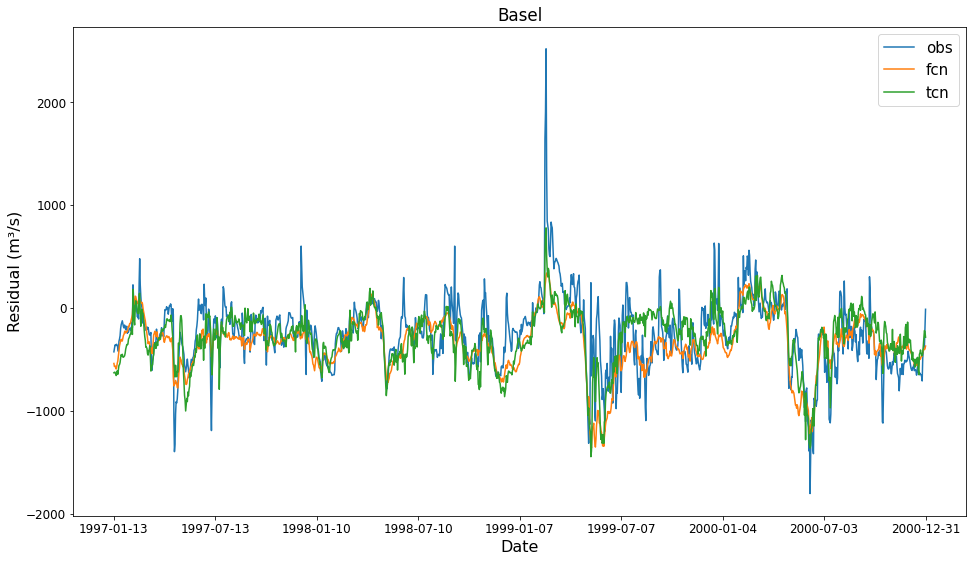

In [28]:
MODEL = ['fcn', 'tcn']  #list of models to be displayed
RESIDUAL = True         #whether to plot the residuals or the streamflow
LOCATION = 'basel'      #location of the plotted data
N_TICKS = 9             #number of ticks in the x axis

#import the data
model_pred = []

with np.load(f'/content/drive/MyDrive/ADS/Final Thesis Project/temp/formatted_data/{LOCATION}/lag_5.npz') as f:
  _, _, _, y, obs = list(f.values())

for m in MODEL:
  pred = np.load(f'/content/drive/MyDrive/ADS/Final Thesis Project/temp/predictions/{LOCATION}/lag/{m}/{m}_test_5.npy')
  if RESIDUAL:
    pred = pred - obs + y
  model_pred.append(pred)

if RESIDUAL:
  obs = y

q = pd.read_csv('/content/drive/MyDrive/ADS/Final Thesis Project/data/q_basel.csv')
dates = np.array(q.iloc[-len(obs):,0])

#plot predictions
plt.figure(figsize = (16,9))
plt.plot(obs, label = "obs")
for i,m in enumerate(MODEL):
  plt.plot(model_pred[i], label = m)

#configure axis
plt.xticks(np.arange(0, len(obs), len(obs)//(N_TICKS-1)), 
           dates[np.arange(0, len(obs), len(obs)//(N_TICKS-1))], fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Date', fontsize = 16)
if RESIDUAL:
  plt.ylabel('Residual (m³/s)', fontsize = 16)
else:
  plt.ylabel('Streamflow (m³/s)', fontsize = 16)
plt.title(LOCATION.capitalize())

plt.legend(prop={'size': 15})
plt.show()


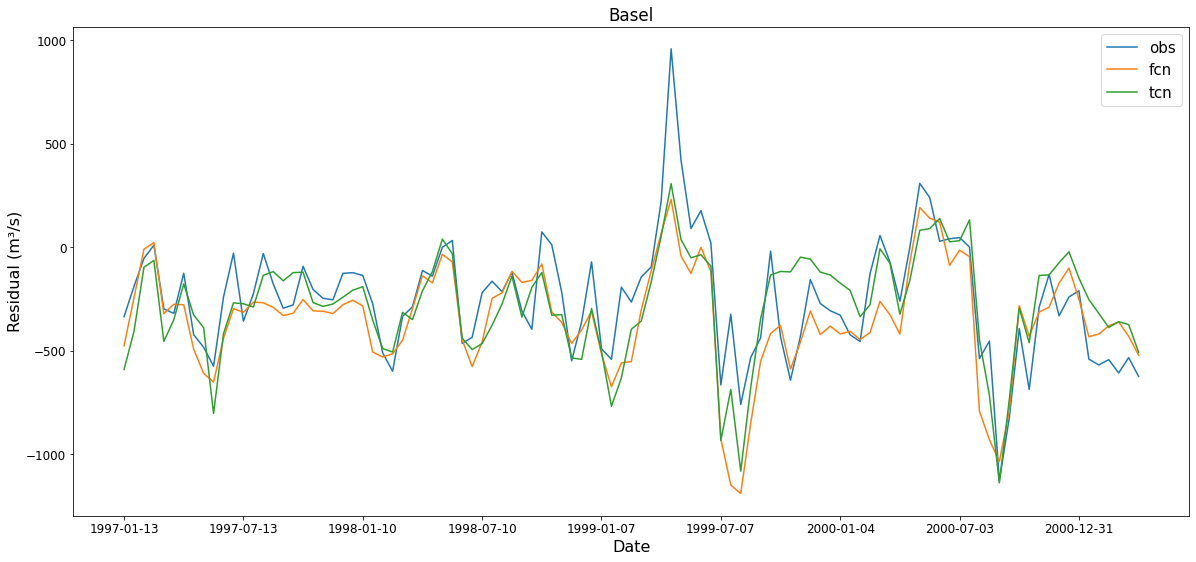

In [31]:
WINDOW = 14 #set time window for smoothing

#define a smoothing function
def smooth_fun(y, window):
  new_len = len(y)//window
  smooth_y = np.zeros((new_len))
  for i in range(new_len):
    smooth_y[i] = np.mean(y[i*window:i*window+window])
  return smooth_y

#plot smoothed predictions
plt.figure(figsize = (20,9))
plt.plot(smooth_fun(obs, WINDOW), label = "obs")
for i,m in enumerate(MODEL):
  plt.plot(smooth_fun(model_pred[i], WINDOW), label = m)

#configure axis
plt.xticks(np.arange(0, len(obs)//WINDOW +1, len(obs)//(WINDOW*(N_TICKS-1))), 
           dates[np.arange(0, len(obs) + 1, len(obs)//(N_TICKS-1))], 
           fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Date', fontsize = 16)
if RESIDUAL:
  plt.ylabel('Residual (m³/s)', fontsize = 16)
else:
  plt.ylabel('Streamflow (m³/s)', fontsize = 16)
plt.title(LOCATION.capitalize())

plt.legend(prop={'size': 15})
plt.savefig('/content/drive/MyDrive/ADS/Final Thesis Project/output/ann_obs_pcr.png')

## Performance boxplots and difference significativity

TCN-FCN with lag basel t-test: Ttest_indResult(statistic=1.841125224324825, pvalue=0.10658611021227304)
TCN-FCN with lag lobith t-test: Ttest_indResult(statistic=0.09562237558381184, pvalue=0.9261739574618186)


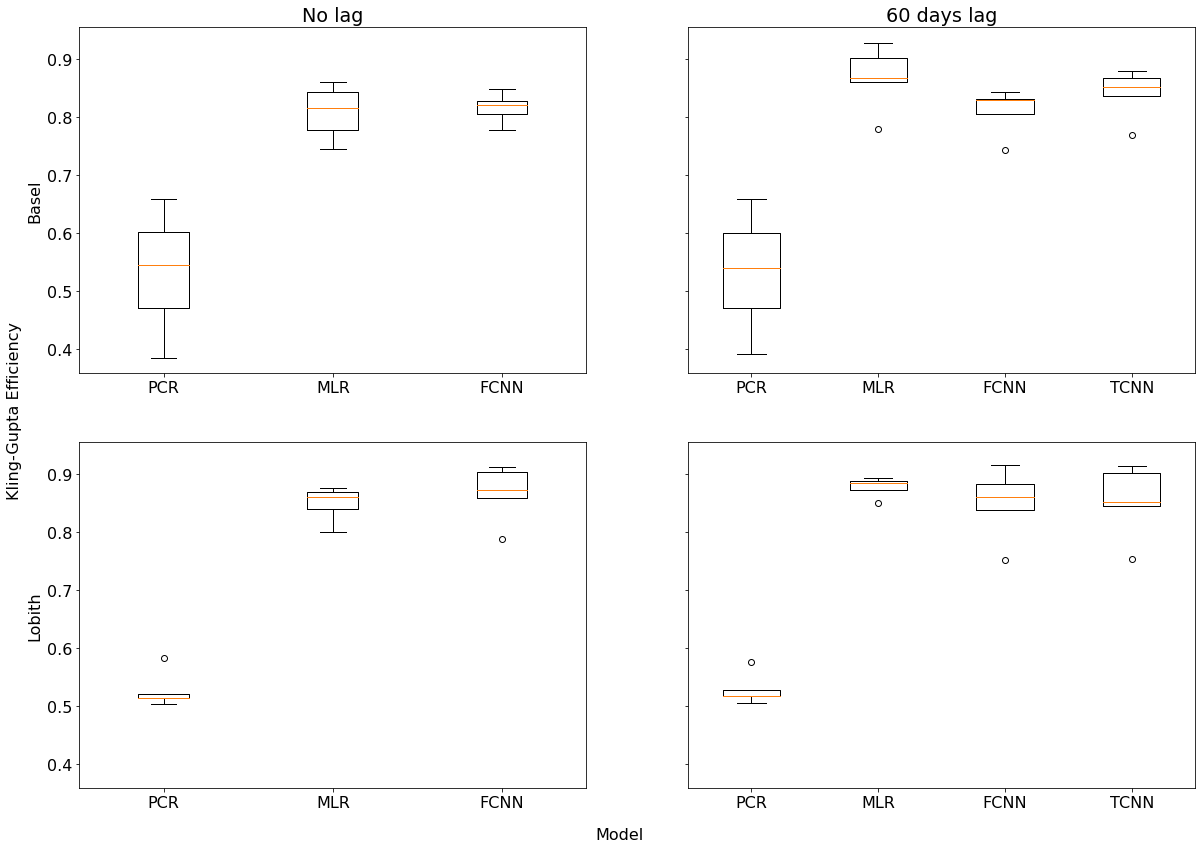

In [ ]:
from scipy.stats import ttest_ind

kge_basel_nlag = {'PCR':[0.385, 0.470, 0.545, 0.601, 0.658], 
                  'MLR':[0.745, 0.843, 0.778, 0.860, 0.815], 
                  'FCNN':[0.778, 0.827, 0.805, 0.848, 0.821]}

kge_basel_ylag = {'PCR':[0.392, 0.471, 0.540, 0.600, 0.659], 
                  'MLR':[0.860, 0.927, 0.866, 0.902, 0.779], 
                  'FCNN':[0.742, 0.843, 0.829, 0.831, 0.804],
                  'TCNN':[0.769, 0.879, 0.836, 0.851, 0.867]}

kge_lobith_nlag = {'PCR':[0.521, 0.513, 0.583, 0.513, 0.504], 
                   'MLR':[0.860, 0.868, 0.876, 0.800, 0.839], 
                   'FCNN':[0.859, 0.911, 0.873, 0.904, 0.788]}

kge_lobith_ylag = {'PCR':[0.528, 0.518, 0.576, 0.517, 0.505], 
                   'MLR':[0.872, 0.885, 0.849, 0.887, 0.893], 
                   'FCNN':[0.837, 0.883, 0.860, 0.915, 0.751],
                   'TCNN':[0.902, 0.852, 0.844, 0.914, 0.753]}


print('TCN-FCN with lag basel t-test:', ttest_ind(kge_basel_ylag['MLR'], kge_basel_ylag['FCNN'], equal_var=False))
print('TCN-FCN with lag lobith t-test:', ttest_ind(kge_lobith_ylag['TCNN'], kge_lobith_ylag['FCNN'], equal_var=False))


plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(2,2, sharey = 'all', figsize = (20,14)) #sharex = 'col'
axs[0,0].boxplot(kge_basel_nlag.values())
axs[0,0].set_xticklabels(kge_basel_nlag.keys())
axs[0,0].set_title('No lag')
axs[0,0].set_ylabel('Basel')

axs[0,1].boxplot(kge_basel_ylag.values())
axs[0,1].set_xticklabels(kge_basel_ylag.keys())
axs[0,1].set_title('60 days lag')

axs[1,0].boxplot(kge_lobith_nlag.values())
axs[1,0].set_xticklabels(kge_lobith_nlag.keys())
axs[1,0].set_ylabel('Lobith')

axs[1,1].boxplot(kge_lobith_ylag.values())
axs[1,1].set_xticklabels(kge_lobith_ylag.keys())

fig.text(0.5, 0.075, 'Model', ha='center')
fig.text(0.075, 0.5, 'Kling-Gupta Efficiency', va='center', rotation='vertical')

plt.savefig('/content/drive/MyDrive/ADS/Final Thesis Project/output/performance_boxplots.png',bbox_inches='tight')

## Performance under different streamflow values

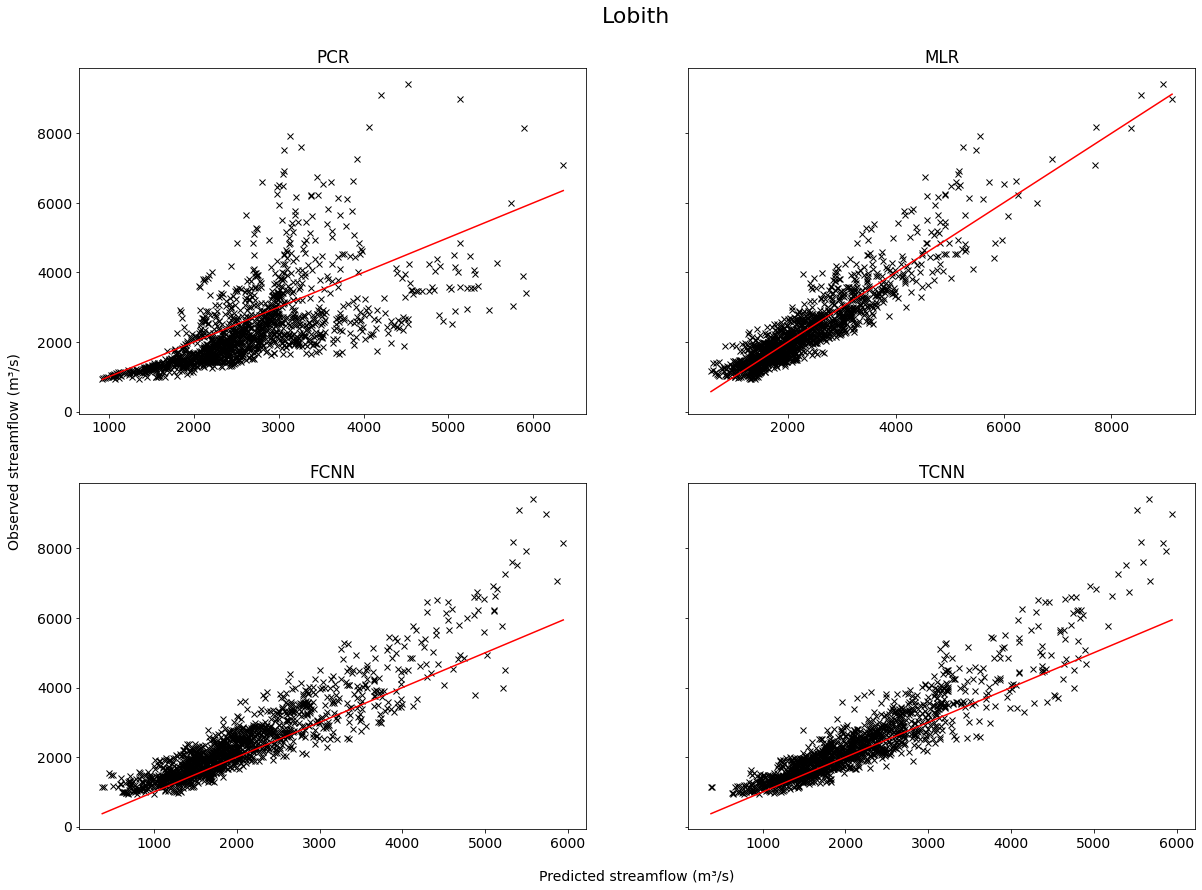

In [4]:
LOCATION = 'lobith'

pcr = np.load(f'/content/drive/MyDrive/ADS/Final Thesis Project/temp/predictions/{LOCATION}/lag/pcr/pcr_test_5.npy')
mlr = np.load(f'/content/drive/MyDrive/ADS/Final Thesis Project/temp/predictions/{LOCATION}/lag/mlr/mlr_test_5.npy')
fcn = np.load(f'/content/drive/MyDrive/ADS/Final Thesis Project/temp/predictions/{LOCATION}/lag/fcn/fcn_test_5.npy')
tcn = np.load(f'/content/drive/MyDrive/ADS/Final Thesis Project/temp/predictions/{LOCATION}/lag/tcn/tcn_test_5.npy')

with np.load(f'/content/drive/MyDrive/ADS/Final Thesis Project/temp/formatted_data/{LOCATION}/lag_5.npz') as f:
  _, _, _, y, obs = list(f.values())

plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(2,2, sharey = 'all', figsize = (20,14))

axs[0,0].plot(pcr, obs, 'kx')
axs[0,0].plot(range(int(pcr.min()), int(pcr.max())), range(int(pcr.min()), int(pcr.max())), 'r')
axs[0,0].set_title('PCR')

axs[0,1].plot(mlr, obs, 'kx')
axs[0,1].plot(range(int(mlr.min()), int(mlr.max())), range(int(mlr.min()), int(mlr.max())), 'r')
axs[0,1].set_title('MLR')

axs[1,0].plot(fcn, obs, 'kx')
axs[1,0].plot(range(int(fcn.min()), int(fcn.max())), range(int(fcn.min()), int(fcn.max())), 'r')
axs[1,0].set_title('FCNN')

axs[1,1].plot(tcn, obs, 'kx')
axs[1,1].plot(range(int(tcn.min()), int(tcn.max())), range(int(tcn.min()), int(tcn.max())), 'r')
axs[1,1].set_title('TCNN')

fig.text(0.512, 0.075, 'Predicted streamflow (m³/s)', ha='center')

fig.text(0.512, 1 - 0.075, LOCATION.capitalize(), ha='center', fontsize = 22)

fig.text(0.075, 0.5, 'Observed streamflow (m³/s)', va='center', rotation='vertical')

plt.savefig(f'/content/drive/MyDrive/ADS/Final Thesis Project/output/obs_vs_pred_{LOCATION}.png',bbox_inches='tight')